In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import OrderedDict

In [2]:
!pip install torchsummary

In [4]:
from torchsummary import summary

In [5]:
# By defalt, set device to the CPU
deviceFlag = torch.device('cpu')

# Defalut is CPU, but as long as GPU is avaliable, then use GPU
if torch.cuda.is_available():
    print(f'Found {torch.cuda.device_count()} GPUs.')
    deviceFlag = torch.device('cuda:0') # Manually pick your cuda device. By default is 'cuda:0'

print(f'Now the deivce is set to {deviceFlag}')

Now the deivce is set to cpu


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
import random

In [8]:
 # Define the dataset class (modified to include a split parameter)
class WasteDataset:
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)


        return image, label

In [9]:
ROOTDIR = "/content/drive/MyDrive/Colab Notebooks/Recyclable and Household Waste Classification/images/images"

In [10]:
training_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # For GPU purpose
    transforms.Normalize([0.485, 0.456, 0.406], # RGB mean & std estied on ImageNet
                         [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # RGB mean & std estied on ImageNet
                         [0.229, 0.224, 0.225])
])

testing_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # RGB mean & std estied on ImageNet
                         [0.229, 0.224, 0.225])
])

In [11]:
train_data = WasteDataset(root_dir=ROOTDIR, split="train", transform=training_transforms)
val_data = WasteDataset(root_dir=ROOTDIR, split="val", transform=validation_transforms)
test_data = WasteDataset(root_dir=ROOTDIR, split="test", transform=testing_transforms)

In [12]:
print(f"Train size: {len(train_data)}")
print(f"Val size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 9000
Val size: 3000
Test size: 3000


In [13]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [14]:
from PIL import Image
def visualize_dataset(dataset, num_images=16, cols=4):
    """
    Visualizes a grid of sample images from the dataset.

    Parameters:
        dataset (WasteDataset): The dataset to visualize.
        num_images (int): Number of images to display.
        cols (int): Number of columns in the grid.
    """
    plt.figure(figsize=(15, 15))
    indices = random.sample(range(len(dataset)), num_images)
    rows = num_images // cols

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        plt.subplot(rows, cols, i + 1)
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        plt.imshow(image)
        plt.title(dataset.classes[label])
        plt.axis('off')

    plt.show()

In [15]:
# Visualize the dataset
visualize_dataset(test_data, num_images=9, cols=3)

Output hidden; open in https://colab.research.google.com to view.

In [16]:
# Create DataLoaders
batch_size = 100
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [17]:
classes = sorted(os.listdir(ROOTDIR))
classes

['aerosol_cans',
 'aluminum_food_cans',
 'aluminum_soda_cans',
 'cardboard_boxes',
 'cardboard_packaging',
 'clothing',
 'coffee_grounds',
 'disposable_plastic_cutlery',
 'eggshells',
 'food_waste',
 'glass_beverage_bottles',
 'glass_cosmetic_containers',
 'glass_food_jars',
 'magazines',
 'newspaper',
 'office_paper',
 'paper_cups',
 'plastic_cup_lids',
 'plastic_detergent_bottles',
 'plastic_food_containers',
 'plastic_shopping_bags',
 'plastic_soda_bottles',
 'plastic_straws',
 'plastic_trash_bags',
 'plastic_water_bottles',
 'shoes',
 'steel_food_cans',
 'styrofoam_cups',
 'styrofoam_food_containers',
 'tea_bags']

In [18]:
len(classes)

30

In [19]:
class WasteModel2(nn.Module):
    def __init__(self, num_classes=30):
        super(WasteModel2, self).__init__()
#         self.num_classes = num_classes
        self.layers = nn.ModuleDict(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('dropout1', nn.Dropout(p=0.25)),

            ('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('dropout2', nn.Dropout(p=0.25)),

            ('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)),
            ('relu3', nn.ReLU()),
            ('pool3', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('dropout3', nn.Dropout(p=0.25)),

            ('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('relu4', nn.ReLU()),
            ('pool4', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('dropout4', nn.Dropout(p=0.25)),

            ('conv5', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('relu5', nn.ReLU()),
            ('pool5', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('dropout5', nn.Dropout(p=0.25)),

            ('flatten', nn.Flatten()),
            ('fc1', nn.Linear(in_features=512 * 7 * 7, out_features=512)),  # Adjusted this according to the input size
            ('relu6', nn.ReLU()),
            ('dropout6', nn.Dropout(p=0.5)),
            ('fc2', nn.Linear(in_features=512, out_features=num_classes))
        ]))

    def forward(self, x):
        for layer in self.layers.values():
            x = layer(x)
        return x

In [20]:
for images, labels in train_loader:
    print(labels)
    break

tensor([10, 23, 20,  3, 28, 18, 26, 27,  7,  9, 16, 20,  8,  9,  6, 13, 12, 14,
         5,  5, 12, 21, 15, 27, 19, 19, 13, 19, 17,  0,  7, 28, 14, 24, 16,  4,
        22, 28, 21, 10, 24, 16, 13,  1, 21, 18,  6,  6, 19,  4,  1, 28, 28,  4,
        20, 20, 25,  2,  1, 19, 14, 15, 12, 28,  4, 12, 10, 23,  9, 22,  7,  6,
         4,  0,  5,  8, 29, 18, 23, 23, 11, 16, 18, 15, 21,  6, 16,  5, 23,  1,
        23,  9, 28,  6, 16, 22, 26,  0, 22, 24])


In [21]:
# Initialize the model, loss function, and optimizer
model = WasteModel2()
model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)
# model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
           Dropout-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
           Dropout-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
             ReLU-10          [-1, 128, 56, 56]               0
        MaxPool2d-11          [-1, 128, 28, 28]               0
          Dropout-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         295,168
             ReLU-14          [-1, 256,

In [23]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(
                    f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}"
                )
                running_loss = 0.0

    print("Finished Training")

def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss:.3f}, Accuracy: {accuracy:.2f}%")
    return test_loss, accuracy

In [24]:
from sklearn.metrics import accuracy_score
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        assert torch.min(labels) >= 0 and torch.max(labels) < 30, "Labels out of range"
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            assert torch.min(labels) >= 0 and torch.max(labels) < 30, "Labels out of range"
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

# Plotting function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Main training loop
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=25):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [25]:
num_epochs = 10

Epoch 1/10
Train Loss: 2.5552, Train Accuracy: 0.2636
Val Loss: 2.3392, Val Accuracy: 0.3383
Epoch 2/10
Train Loss: 2.4886, Train Accuracy: 0.2806
Val Loss: 2.2424, Val Accuracy: 0.3480
Epoch 3/10
Train Loss: 2.4653, Train Accuracy: 0.2930
Val Loss: 2.2826, Val Accuracy: 0.3540
Epoch 4/10
Train Loss: 2.4461, Train Accuracy: 0.2961
Val Loss: 2.1728, Val Accuracy: 0.3787
Epoch 5/10
Train Loss: 2.3958, Train Accuracy: 0.3081
Val Loss: 2.1722, Val Accuracy: 0.3787
Epoch 6/10
Train Loss: 2.3650, Train Accuracy: 0.3161
Val Loss: 2.1025, Val Accuracy: 0.4047
Epoch 7/10
Train Loss: 2.3083, Train Accuracy: 0.3318
Val Loss: 1.9913, Val Accuracy: 0.4203
Epoch 8/10
Train Loss: 2.2882, Train Accuracy: 0.3397
Val Loss: 2.0212, Val Accuracy: 0.4143
Epoch 9/10
Train Loss: 2.2491, Train Accuracy: 0.3463
Val Loss: 1.9004, Val Accuracy: 0.4643
Epoch 10/10
Train Loss: 2.2239, Train Accuracy: 0.3596
Val Loss: 1.9416, Val Accuracy: 0.4320


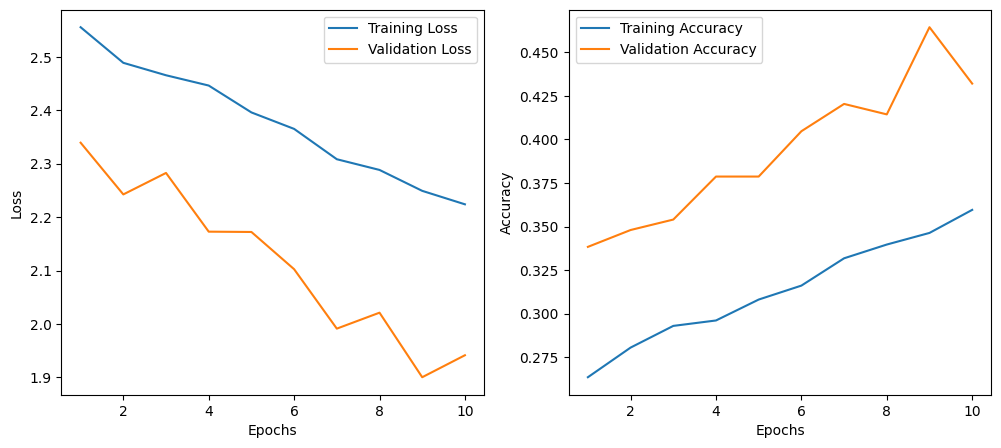

In [29]:
history = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs)

In [30]:
# Assuming 'model' is your PyTorch model object
torch.save(model.state_dict(), 'wastemodel_2.pth')

In [31]:
def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    print(f'Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}')

    return epoch_loss, epoch_acc

def plot_test_metrics(test_losses, test_accuracies):
    epochs = range(1, len(test_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plot test loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, test_losses, 'bo-', label='Test loss')
    plt.title('Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'ro-', label='Test accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [32]:
test_loss, test_acc = test(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 1.9560, Test Accuracy: 0.4420
Test Loss: 1.9560, Test Acc: 0.4420
